In [7]:
import os, sys

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='paper', style='ticks')

In [17]:
def read_data(infile, parse_col, date_str):
    """
    Function to read data.

    Parameters
    ----------
    infile : str
        Path to data.
    parse_col : str
        Column name of time variable.
    date_str : str
        String for datetime conversion.

    returns
    -------
    data : pd.DataFrame
    """
    def dateparse(x): return pd.datetime.strptime(x, date_str)
    data = pd.read_csv(infile, parse_dates=[parse_col], date_parser=dateparse)
    data.index = data[parse_col]
    return data.drop(columns=[parse_col], axis=1)

In [38]:
# define base directory
inpath = sys.path[0]
print(os.listdir(inpath))

# read the backscatter and soil moisture data
data = read_data(infile=os.path.join(inpath, 'Asheville-13-S_data.csv'),
                 parse_col='Time', date_str='%Y-%m-%d %H:%M:%S.%f')
print(data.head())

# read ancillary data and store as dict
site_specs_df = pd.read_csv(os.path.join(inpath, 'Asheville-13-S_sitespecifics.csv'),
                        delimiter=':', header=None)
site_specs = {}
for k, v in zip(site_specs_df.loc[:, 0], site_specs_df.loc[:, 1]):
    site_specs[k] = v
print(site_specs)

['Asheville-13-S_sitespecifics.csv', 'Asheville-13-S_data.csv', 'ex2.ipynb', '.ipynb_checkpoints']
                            SSM_IS  SSM_LSM     SIG40     SLOPE     CURVE  \
Time                                                                        
2010-01-18 16:00:37.500004   0.336  0.29664 -8.136676 -0.087746  0.000203   
2010-01-20 02:58:58.124012   0.342  0.27505 -8.136666 -0.087717  0.000218   
2010-01-21 14:58:35.624999   0.350  0.38549 -7.747195 -0.087693  0.000227   
2010-01-22 02:17:33.750000   0.361  0.33030 -8.009717 -0.087689  0.000238   
2010-01-23 01:56:58.124999   0.351  0.31426 -8.311224 -0.087646  0.000247   

                                sigf      sigm      siga       incf  \
Time                                                                  
2010-01-18 16:00:37.500004 -8.175597 -8.153164 -8.081265  59.249040   
2010-01-20 02:58:58.124012 -8.241362 -8.011751 -8.156887  46.319836   
2010-01-21 14:58:35.624999 -7.693698 -7.728050 -7.819838  52.360992   
2010-0

array([<matplotlib.axes._subplots.AxesSubplot object at 0x11573dac8>,
      dtype=object)

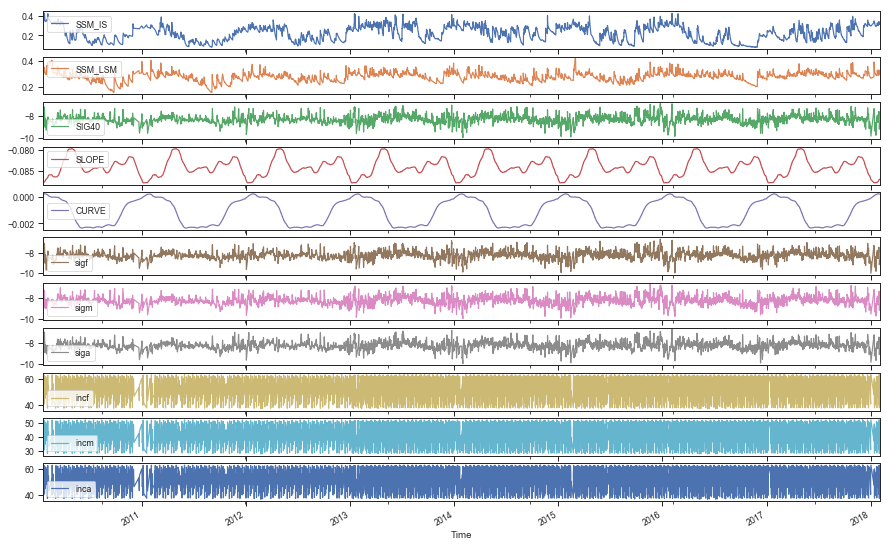

In [40]:
data.plot(subplots=True, figsize=(15,10))

## TU Wien method

In [ ]:
wet_ref = 40
dry_ref = 25